In [105]:
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve_fft
import numpy as np
from regions import Regions
import astropy.io.fits as pyfits
import os
from reproject import reproject_interp
from scipy import ndimage, misc
from astropy.wcs import WCS
import pyregion
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
def open_files(file):
    filename = file
    hdu  = fits.open(filename)[0]
    wcs=WCS(hdu.header)
    if hdu.header['NAXIS']==3:
        wcs=wcs.dropaxis(2)
    return hdu, wcs

def fig(file,row,col):
    mpl.rcParams['font.sans-serif'] = "georgia"
    mpl.rcParams['mathtext.fontset'] = "cm" 
    hdu,wcs=file                                            #unpacking file

    fig = plt.figure(figsize=(16, 6))
    for i in range(row * col):
        coord = plt.subplot(row, col, i + 1, projection=wcs, slices=('x', 'y'))
        lon = coord.coords[0]
        lat = coord.coords[1]

        return coord.imshow(hdu.data,norm='log')


def plot_coords_galactic(file, min_coord, max_coord): 
    hdu,wcs=file  
    min_galactic = SkyCoord(frame="galactic", l=min_coord[0] , b=min_coord[1], unit=(u.deg)) #found on simbad
    min_pixel = wcs.world_to_pixel(min_galactic)

    max_galactic = SkyCoord(frame="galactic", l=max_coord[0] , b=max_coord[1], unit=(u.deg)) #found on simbad
    max_pixel = wcs.world_to_pixel(max_galactic)

    return min_pixel,max_pixel

def single_coord(file,coord):
    hdu,wcs=file 
    pos = SkyCoord(frame="galactic", l=coord[0], b=coord[1], unit=(u.deg))
    x, y = wcs.world_to_pixel(pos)
    return (x, y)
def median_flux(file):
    hdu,wcs=file
    region_filename = 'data/Terrier_2018_all.reg'
    regions = read_ds9(region_filename)
    mask = np.zeros(hdu.data.shape, dtype=bool)
    for i in range((12)):
        pixel_region = regions[i].to_pixel(wcs)
        if pixel_region.to_mask(mode='center').to_image(hdu.shape) is not None:
            mask |= pixel_region.to_mask(mode='center').to_image(hdu.shape).astype(bool)
    result = np.ma.masked_array(hdu.data, mask)
    med_flux=np.nanmedian(result)
    return med_flux

def is_regions_file(file_path):
    # Get the file extension
    _, file_extension = os.path.splitext(file_path)
    
    # Check if the extension is .reg
    if file_extension.lower() == '.reg':
        return True
    else:
        return False

In [72]:
class Person:
    def __init__(self, sub_dict):
        """
        takes in a dictionary of names and eliipse region
        region: List of regions (e.g., read from a file or passed as a parameter)
        name: List of region names corresponding to each region
        """
        self.region = list(sub_dict.keys())
        self.name = list(sub_dict.values())

    def __getitem__(self, index):
        # Allows you to access the regions list as if it's a giant list
        return self.region[index]

    def set_mask(self, name, mask_filled):
        """
        Sets the mask_filled attribute for the given region.

        Parameters:
        name: str
            The name of the region to which the mask should be added.
        mask_filled: ndarray
            The mask to assign to the region.
        """
        if name in self.regions:
            self.regions[name]['mask'] = mask_filled
        else:
            raise KeyError(f"Region '{name}' not found.")

    def get_mask(self, name):
        """
        Returns the mask for a given region.

        Parameters:
        name: str
            The name of the region for which the mask should be returned.
        """
        return self.regions[name]['mask']

'''   def apply_masks(self, hdu, wcs):
        """
        Applies the regions to the flux_ratio_map and creates a combined mask.
        
        Parameterd:
        flux_ratio_map: The map you're applying masks to.
        wcs_smoothed_spitz_8um: The WCS transformation for the regions

        Returns:
        individual masks
        """
        mask = np.zeros(hdu.data.shape, dtype=bool)
        
        # Iterate through the regions and apply masks
        for i in range(num_regions):
            pixel_region = self.region[i].to_pixel(wcs)
            region_mask = pixel_region.to_mask(mode='center').to_image(hdu.data.shape)

            if region_mask is not None:
                mask |= region_mask.astype(bool)

        # Return masked array based on the combined mask
        masked_data = np.ma.masked_array(hdu.data, ~mask)
        return masked_data
'''


'   def apply_masks(self, hdu, wcs):\n        """\n        Applies the regions to the flux_ratio_map and creates a combined mask.\n        \n        Parameterd:\n        flux_ratio_map: The map you\'re applying masks to.\n        wcs_smoothed_spitz_8um: The WCS transformation for the regions\n\n        Returns:\n        individual masks\n        """\n        mask = np.zeros(hdu.data.shape, dtype=bool)\n        \n        # Iterate through the regions and apply masks\n        for i in range(num_regions):\n            pixel_region = self.region[i].to_pixel(wcs)\n            region_mask = pixel_region.to_mask(mode=\'center\').to_image(hdu.data.shape)\n\n            if region_mask is not None:\n                mask |= region_mask.astype(bool)\n\n        # Return masked array based on the combined mask\n        masked_data = np.ma.masked_array(hdu.data, ~mask)\n        return masked_data\n'

In [23]:
class smoothing(Person):
    def smooth8um(file, masked_data,output_filename):
        """
        Opens background file, smooths masked_data and writes it to a FITS file.
        
        Parameters:
        file: File filename for background file
        masked_data: numpy array that is already masked
        file_mask: filename/file for mask
        
        Returns:
        mask filled: The combined binary mask after reprojection and hole-filling
        """
        # Load the FITS file and extract the background data
        background_file = fits.open(file)
        background = background_file[0].data
        header = background_file[0].header
        background_file.close()

        # Gaussian smoothing parameters
        r_eff = 3  # arcmin
        res = r_eff / np.sqrt(2)
        test_res = res * 60  # arcmin to arcseconds
        spitz_res = 1.98 / 2.355  # FWHM to sigma (8um channel FWHM=1.98 arcseconds)

        # Calculate sigma for Gaussian kernel
        sig_gauss = np.sqrt(test_res**2 - spitz_res**2)
        kern = sig_gauss / 1.2  # arcsec/pixel

        # Perform Gaussian convolution
        smoothed = convolve_fft(background, Gaussian2DKernel(x_stddev=kern), normalize_kernel=True, preserve_nan=False, allow_huge=True)

        # Convert masked_data to a regular NumPy array
        masked_data_array = np.ma.filled(masked_data, np.nan)  # Replace masked values with np.nan or any other value

        # Create HDUs
        hdu_smoothed = fits.PrimaryHDU(data=smoothed, header=header)
        hdu_masked_data = fits.ImageHDU(data=masked_data_array, header=header)

        # Create an HDU list and write to a FITS file
        hdul = fits.HDUList([hdu_smoothed, hdu_masked_data])
        output_filename = output_filename
        hdul.writeto(output_filename, overwrite=True)

    def smooth70um(filename):
        """
        Opens 70um file, smooths it, and then writes it to a FITS file.
        
        Parameters:
        file: File filename for background file
        
        Returns:
        FITS File: The combined binary mask after reprojection and hole-filling
        """

        #smoothing 70um data
        hers70um =filename
        hers_70um_data = pyfits.open(hers70um)[0].data
        sig_gauss = np.sqrt(36**2 - 6**2 )
        kern = sig_gauss/(3.2) #arcsec/pix

        h_hers70 = pyfits.getheader(hers70um)

        smoothed_nans_70um = convolve_fft(hers_70um_data, Gaussian2DKernel(x_stddev=kern), normalize_kernel=True, preserve_nan=False, allow_huge=True)
        pyfits.writeto('70um_smoothed_conv36.fits'.format(Cloud,Cloud), smoothed_nans_70um, h_hers70, overwrite=True) 


In [24]:
'''class individual_masks(Person):
    def reproject_masks(self, file, file_mask):
        """
        Opens FITS files, reprojects the data, and creates binary mask.
        
        Parameters:
        file: File filename for background file
        file_mask: filename/file for mask
        
        Returns:
        mask filled: The combined binary mask after reprojection and hole-filling
        """
        # Open FITS files
        data = open_files(file)
        hdu_file, wcs_file = data
        
        file_mask = open_files(file_mask)
        hdu_mask, wcs_mask = file_mask

        # Reproject the masks and results
        result_reproj, _ = reproject_interp((file_mask, wcs_mask), wcs_file, shape_out=hdu_file.data.shape)

        # Step 2: Create binary masks using np.where for outline detection
        mask_outline = np.where(result_reproj > 0, True, False)

        # Step 3: Fill the masks using scipy's binary_fill_holes
        mask_filled = ndimage.binary_fill_holes(mask_outline)
        return mask_filled
    def save_masked_fits(data, mask, wcs, output_filename, bool=False):
        """Creates individual cloud masks including data from original file 
        and saves them to a FITS file.

        Parameters: 
        data: ndarray
            Data from file
        mask: ndarray
            Mask to apply to original file
        wcs: WCS object
            WCS of file
        output_filename: str
            Filename of the new masked file
        bool: boolean
            If True, mask will be a boolean mask
            If False, mask will have data values 
        """
    
        # Check if mask is 2D
        if mask.ndim != 2:
            raise ValueError("Mask must be a 2D array.")

        # Apply the mask to the data (masked values are set to NaN)
        if bool==True:
            masked_data = np.where(mask > 0, 1, np.nan)
        else:
            masked_data = np.where(mask, data, np.nan)

        # Find the bounding box of the mask
        masked_indices = np.where(mask)

        # Check if there are any True values in the mask
        if masked_indices[0].size == 0:
            raise ValueError("The mask contains no True values.")
        
        # Get the bounding box
        min_y, max_y = masked_indices[0].min(), masked_indices[0].max()
        min_x, max_x = masked_indices[1].min(), masked_indices[1].max()
        
        # Crop the data and mask to the bounding box
        cropped_data = masked_data[min_y:max_y + 1, min_x:max_x + 1]
        cropped_mask = mask[min_y:max_y + 1, min_x:max_x + 1]

        # Create a new PrimaryHDU with the cropped masked data
        hdu = fits.PrimaryHDU(cropped_data)

        # Update the header with the WCS info
        hdu.header.update(wcs.to_header())
        
        # Create an HDUList and write to a FITS file
        hdu_masked = fits.HDUList([hdu])
        hdu_masked.writeto(output_filename, overwrite=True)
'''

## Parent class, only takes in ellipse regions from Regions file and adds it to a list

In [153]:
class Person:
    def __init__(self, sub_dict, selected_names=None):
        """
        Takes in a dictionary of names and ellipse regions
        region: List of regions (e.g., read from a file or passed as a parameter)
        name: List of region names corresponding to each region
        selected_names: List of names to filter regions
        """
        self.region = []
        self.name = []
        
        if selected_names:
            for nawhme in selected_names:
                if name in sub_dict:
                    self.region.append(sub_dict[name])
                    self.name.append(name)
        else:
            self.region = list(sub_dict.values())
            self.name = list(sub_dict.keys())
class IndividualMasks(Person):
    def reproject_and_save(self, file, output_filename_template):
        """
        Reprojects the mask, applies it to the data, and saves the masked FITS file for each region.

        Parameters:
        file: str
            Filename for the background file.
        output_filename_template: str
            Template for saving the masked FITS file (should include a placeholder for the region name).
        """
        # Open and unpack the FITS file
        file_data = open_files(file)
        hdu_file, wcs_file = file_data

        # Loop over each region
        for name, region in zip(self.name, self.region):
            # Convert the region to pixel coordinates
            pixel_region = region.to_pixel(wcs_file)
            
            # Create the mask for the region
            region_mask = pixel_region.to_mask(mode='center').to_image(hdu_file.data.shape)
            
            if region_mask is not None:
                ### 1. First Mask: Region with original data, background as NaN ###
                
                # Copy the original data and mask out the background (NaN for background)
                data_with_background_nan = hdu_file.data.copy()
                data_with_background_nan[~region_mask.astype(bool)] = np.nan  # Set background to NaN
                
                # Save the first FITS file (original data within mask, NaN for background)
                output_filename = output_filename_template.format(name)
                self.save_masked_fits(data_with_background_nan, wcs_file, output_filename)

    def save_masked_fits(self, data, wcs, output_filename):
        """
        Saves the masked data into a new FITS file, cropping to the area with valid data.

        Parameters:
        data: ndarray
            Data from the original file with NaNs in the background.
        wcs: WCS object
            WCS of the original file.
        output_filename: str
            Filename of the new masked FITS file.
        """
        # Mask the data to find valid entries
        masked_data = np.ma.masked_invalid(data)

        # Check if there are any valid entries
        if masked_data.count() == 0:
            raise ValueError("The data contains only NaN values; nothing to save.")
        
        # Get the bounding box of the non-NaN data
        min_y, max_y = np.where(~masked_data.mask)[0].min(), np.where(~masked_data.mask)[0].max()
        min_x, max_x = np.where(~masked_data.mask)[1].min(), np.where(~masked_data.mask)[1].max()

        # Crop the data to the bounding box and convert to a regular NumPy array
        cropped_data = masked_data[min_y:max_y + 1, min_x:max_x + 1].data

        # Create a new PrimaryHDU with the cropped masked data
        hdu = fits.PrimaryHDU(cropped_data)

        # Update the header with the WCS info
        hdu.header.update(wcs.to_header())

        # Write the masked data to a new FITS file
        hdu.writeto(output_filename, overwrite=True)
        print(f"Saved cropped masked FITS file: {output_filename}")

regions = Regions.read('Terrier_2018_all.reg', format='ds9')
# Dictionary of contour names and their region indices
contours = {
    'MC1': 0, 'MC2': 1, 'Br1': 2, 'Br2': 3, 'G0.11-0.11': 4, 'Arches': 5, 'DX': 6,
    'Fil. 2011': 7, 'G0.04-0.16': 8, 'G0.02+0.01': 9, 'G0.09-0.02': 10, 'G0.24-0.17': 11,
    'Sgr B': 12, 'Sgr B2': 13, 'G0.74-0.11': 14, 'G0.66-0.13': 15, 'G0.50-0.11': 16,
    'G0.56-0.11': 17, 'Sgr C': 18, 'C1': 19, 'C2': 20, 'C3': 21, 'C4': 22, 'M359.38-0.00': 23,
    'M359.23-0.04a': 24, 'M359.23-0.04b': 25, 'Sgr D core': 26
}
# Create a dictionary of contour names and their corresponding regions
cloud_dict = {name: regions[index] for name, index in contours.items()}

# Specify the names of the regions you want to use
selected_region_names = ['Br1', 'Br2']

# Create a filtered dictionary for the selected regions
sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}

# Instantiate the class with the selected regions
individual_masks = IndividualMasks(sub_dict)

# Call the reproject_and_save method with a template for the output filenames
individual_masks.reproject_and_save(
    'destripe_l000_blue_wgls_rcal_cropped.fits',
    'output_masked_{}.fits' ) # Template where {} will be replaced by the region name


Saved cropped masked FITS file: output_masked_Br1.fits
Saved cropped masked FITS file: output_masked_Br2.fits


# Change below this line

In [94]:
class Person:
    def __init__(self, sub_dict, selected_names=None):
        """
        Takes in a dictionary of names and ellipse regions
        region: List of regions (e.g., read from a file or passed as a parameter)
        name: List of region names corresponding to each region
        selected_names: List of names to filter regions
        """
        self.region = []
        self.name = []
        
        if selected_names:
            for nawhme in selected_names:
                if name in sub_dict:
                    self.region.append(sub_dict[name])
                    self.name.append(name)
        else:
            self.region = list(sub_dict.values())
            self.name = list(sub_dict.keys())

        if boolean_mask:
            masked_data = np.where(mask > 0, 1, np.nan)
        else:
            masked_data = np.where(mask, data, np.nan)

        # Find the bounding box of the mask
        masked_indices = np.where(mask)

        if masked_indices[0].size == 0:
            raise ValueError("The mask contains no True values.")
        
        # Get the bounding box
        min_y, max_y = masked_indices[0].min(), masked_indices[0].max()
        min_x, max_x = masked_indices[1].min(), masked_indices[1].max()

        # Crop the data to the bounding box
        cropped_data = masked_data[min_y:max_y + 1, min_x:max_x + 1]

        # Create a new WCS object for the cropped region
        new_wcs = wcs[min_x:max_x + 1, min_y:max_y + 1]

        # Update the header with the new WCS info
        new_header = new_wcs.to_header()
        # Create a new PrimaryHDU with the cropped masked data
        hdu = fits.PrimaryHDU(cropped_data, header=new_header)
        # Write the masked data to a new FITS file
        hdu_masked = fits.HDUList([hdu])
        hdu_masked.writeto(output_filename, overwrite=True)

    def reproject_and_save(self, file, file_mask, output_filename_template, boolean_mask=False):
        """
        Reprojects the mask, applies it to the data, and saves the masked FITS file for each region.

        Parameters:
        file: str
            Filename for the background file.
        file_mask: str
            Filename for the mask file.
        output_filename_template: str
            Template for saving the masked FITS file (should include a placeholder for the region name).
        boolean_mask: bool, optional
            If True, the mask will be a binary mask.
        """
        for name, region in zip(self.name, self.region):
            # Reproject the mask and get the corresponding WCS and data for the current region
            mask_filled, wcs, data = self.reproject_masks(file, file_mask, region)

            # Generate a unique output filename for each region
            output_filename = output_filename_template.format(name)

            # Save the masked data to a FITS file
            self.save_masked_fits(data, mask_filled, wcs, output_filename, boolean_mask)

# Example usage
regions = Regions.read('Terrier_2018_all.reg', format='ds9')
#dictionary of contour names and their region index in Regions
contours={'MC1':0,'MC2':1,'Br1':2,'Br2':3,'G0.11-0.11':4,'Arches':5,'DX':6,
'Fil. 2011':7,'G0.04-0.16':8,'G0.02+0.01':9,'G0.09-0.02':10,'G0.24-0.17':11,
'Sgr B':12,'Sgr B2':13,'G0.74-0.11':14,'G0.66-0.13':15,'G0.50-0.11':16,
'G0.56-0.11':17,'Sgr C':18,'C1':19,'C2':20,'C3':21,'C4':22,'M359.38-0.00':23,'M359.23-0.04a':24,
'M359.23-0.04b':25,'Sgr D core':26}
# Create a dictionary of contour names and their corresponding regions
cloud_dict = {name: regions[index] for name, index in contours.items()}

# Specify the names of the regions you want to use
selected_region_names = ['Br1', 'Br2']

# Create a filtered dictionary for the selected regions
sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}

clouds_list = Person(sub_dict)  # This will contain only Br1 and Br2 regions
individual_masks = IndividualMasks(sub_dict)  # This will also contain only Br1 and Br2 regions

# Call the reproject_and_save method with a template for the output filenames
individual_masks.reproject_and_save(
    'destripe_l000_blue_wgls_rcal_cropped.fits',
    'Terrier_2018_all.reg',
    'output_masked_{}.fits'  # Template where {} will be replaced by the region name
)


In [97]:
class Person:
    def __init__(self, sub_dict, selected_names=None):
        """
        Takes in a dictionary of names and ellipse regions
        region: List of regions (e.g., read from a file or passed as a parameter)
        name: List of region names corresponding to each region
        selected_names: List of names to filter regions
        """
        self.region = []
        self.name = []
        
        if selected_names:
            for nawhme in selected_names:
                if name in sub_dict:
                    self.region.append(sub_dict[name])
                    self.name.append(name)
        else:
            self.region = list(sub_dict.values())
            self.name = list(sub_dict.keys())

class IndividualMasks(Person):
    def reproject_masks(self, file, file_mask, region):
        """
        Reprojects the data to match the target WCS but not the pixel size.
        """
        data = open_files(file)
        hdu_file, wcs_file = data

        # Initialize an empty mask with the shape of the target data
        target_shape = hdu_file.data.shape  # Get the shape of the target data
        mask = np.zeros(target_shape, dtype=bool)

        # Load the target WCS
        target_wcs = WCS(wcs_file)  # Assuming wcs_file is already in WCS format

        # Convert the region coordinates to the target WCS
        # Assuming `region` has a method to get its coordinates (in sky coordinates)
        region_coordinates = region.get_coordinates()  # Get coordinates of the region in sky

        # Convert the sky coordinates to pixel coordinates in the target WCS
        pixel_coords = target_wcs.world_to_pixel(region_coordinates)

        # Create the mask from the pixel coordinates
        # Assuming pixel_coords is a 2D array with shape (N, 2)
        for x, y in pixel_coords:
            if 0 <= int(y) < target_shape[0] and 0 <= int(x) < target_shape[1]:
                mask[int(y), int(x)] = True  # Set the pixel in the mask

        # Fill holes in the mask using binary_fill_holes if necessary
        mask_filled = ndimage.binary_fill_holes(mask)

        return mask_filled, target_wcs, hdu_file.data

    # ... Rest of the class remains unchanged ...

def save_masked_fits(self, data, mask, wcs, output_filename, boolean_mask=False):
    """
    Saves masked data into a new FITS file.
    Parameters: 
    data: ndarray
        Data from the original file.
    mask: ndarray
        Mask to apply to the data.
    wcs: WCS object
        WCS of the original file.
    output_filename: str
        Filename of the new masked FITS file.
    boolean_mask: bool, optional
        If True, the mask will contain binary values (1 for True, NaN for False).
        If False, the mask will apply original data values masked by NaNs.
    """
    # Check if mask is 2D
    if mask.ndim != 2:
        raise ValueError("Mask must be a 2D array.")

    # Apply the mask to the data (set masked values to NaN)
    if boolean_mask:
        masked_data = np.where(mask > 0, 1, np.nan)
    else:
        masked_data = np.where(mask, data, np.nan)

    # Find the bounding box of the mask
    masked_indices = np.where(mask)

    if masked_indices[0].size == 0:
        raise ValueError("The mask contains no True values.")
    
    # Get the bounding box
    min_y, max_y = masked_indices[0].min(), masked_indices[0].max()
    min_x, max_x = masked_indices[1].min(), masked_indices[1].max()

    # Crop the data to the bounding box
    cropped_data = masked_data[min_y:max_y + 1, min_x:max_x + 1]

    # Create a new PrimaryHDU with the cropped masked data
    hdu = fits.PrimaryHDU(cropped_data)

    # Update the header with the WCS info
    hdu.header.update(wcs.to_header())  # Correct way to get the WCS header
    
    # Write the masked data to a new FITS file
    hdu_masked = fits.HDUList([hdu])
    hdu_masked.writeto(output_filename, overwrite=True)

    def reproject_and_save(self, file, file_mask, output_filename_template, boolean_mask=False):
        """
        Reprojects the mask, applies it to the data, and saves the masked FITS file for each region.

        Parameters:
        file: str
            Filename for the background file.
        file_mask: str
            Filename for the mask file.
        output_filename_template: str
            Template for saving the masked FITS file (should include a placeholder for the region name).
        boolean_mask: bool, optional
            If True, the mask will be a binary mask.
        """
        for name, region in zip(self.name, self.region):
            # Reproject the mask and get the corresponding WCS and data for the current region
            mask_filled, wcs, data = self.reproject_masks(file, file_mask, region)

            # Generate a unique output filename for each region
            output_filename = output_filename_template.format(name)

            # Save the masked data to a FITS file
            self.save_masked_fits(data, mask_filled, wcs, output_filename, boolean_mask)

# Example usage
regions = Regions.read('Terrier_2018_all.reg', format='ds9')
#dictionary of contour names and their region index in Regions
contours={'MC1':0,'MC2':1,'Br1':2,'Br2':3,'G0.11-0.11':4,'Arches':5,'DX':6,
'Fil. 2011':7,'G0.04-0.16':8,'G0.02+0.01':9,'G0.09-0.02':10,'G0.24-0.17':11,
'Sgr B':12,'Sgr B2':13,'G0.74-0.11':14,'G0.66-0.13':15,'G0.50-0.11':16,
'G0.56-0.11':17,'Sgr C':18,'C1':19,'C2':20,'C3':21,'C4':22,'M359.38-0.00':23,'M359.23-0.04a':24,
'M359.23-0.04b':25,'Sgr D core':26}
# Create a dictionary of contour names and their corresponding regions
cloud_dict = {name: regions[index] for name, index in contours.items()}

# Specify the names of the regions you want to use
selected_region_names = ['Br1', 'Br2']

# Create a filtered dictionary for the selected regions
sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}

clouds_list = Person(sub_dict)  # This will contain only Br1 and Br2 regions
individual_masks = IndividualMasks(sub_dict)  # This will also contain only Br1 and Br2 regions

# Call the reproject_and_save method with a template for the output filenames
individual_masks.reproject_and_save(
    'destripe_l000_blue_wgls_rcal_cropped.fits',
    'Terrier_2018_all.reg',
    'output_masked_{}.fits'  # Template where {} will be replaced by the region name
)


NameError: name 'read_ds9' is not defined

In [100]:


# Load your FITS data (the file to which you want to reproject)
data_file = "destripe_l000_blue_wgls_rcal_cropped.fits"  # Replace with your FITS file
hdu_data = fits.open(data_file)[0]
data = hdu_data.data
wcs_data = WCS(hdu_data.header)

# Load the regions file (ellipses)
region_file = "Terrier_2018_all.reg"  # Replace with your regions file
regions_list = Regions.read(region_file)

# Load the WCS of the regions file (if available) or create it
# For this example, I'll assume you have the WCS of the regions file.
# Replace wcs_of_regions with your actual WCS
# You may need to check your regions file or headers to set this properly
wcs_of_regions = WCS()  # Initialize with your region file's WCS

# Reproject the FITS data to match the WCS of the regions file (if needed)
# Skip this step if the WCS are already aligned
data_reproj, footprint = reproject_interp((data, wcs_data), wcs_of_regions, shape_out=data.shape)

# Initialize an empty mask
mask = np.zeros(data.shape, dtype=bool)

# Loop through each region and create a mask
for region in regions_list:
    if isinstance(region, regions.EllipseSkyRegion):
        # Convert to pixel coordinates in the WCS of the FITS file
        pixel_region = region.to_pixel(wcs_of_regions)
        # Create a mask for the reprojected ellipse
        region_mask = pixel_region.to_mask(mode='center').to_image(data.shape)
        # Combine the masks using logical OR
        mask |= region_mask  # Use logical OR to accumulate the masks

# Step 3: Fill the masks using scipy's binary_fill_holes to fill inside the outlines
mask_filled = ndimage.binary_fill_holes(mask)

# Visualize the filled mask
plt.imshow(mask_filled, origin='lower', cmap='gray')
plt.colorbar()
plt.title("Reprojected and Filled Mask from Ellipses")
plt.show()

# Optionally save the mask to a new FITS file
hdu_masked = fits.PrimaryHDU(mask_filled.astype(int), header=hdu_data.header)
hdu_masked.writeto('reprojected_filled_mask.fits', overwrite=True)


ValueError: Input WCS has celestial components but output WCS does not

In [25]:
region_name='Terrier_2018_all.reg'
r = pyregion.open(region_name)
contours = {
    'MC1': 0, 'MC2': 1, 'Br1': 2, 'Br2': 3, 'G0.11-0.11': 4, 'Arches': 5, 
    'DX': 6, 'Fil. 2011': 7, 'G0.04-0.16': 8, 'G0.02+0.01': 9, 'G0.09-0.02': 10, 
    'G0.24-0.17': 11, 'Sgr B': 12, 'Sgr B2': 13, 'G0.74-0.11': 14, 
    'G0.66-0.13': 15, 'G0.50-0.11': 16, 'G0.56-0.11': 17, 'Sgr C': 18, 
    'C1': 19, 'C2': 20, 'C3': 21, 'C4': 22, 
    'M359.38-0.00': 23, 'M359.23-0.04a': 24, 'M359.23-0.04b': 25, 
    'Sgr D core': 26
}

# Create a dictionary of contour names and their corresponding regions
cloud_dict = {name: r[index] for name, index in contours.items()}

# Specify the names of the regions you want to use
selected_region_names = ['Br1', 'Br2']

# Create a filtered dictionary for the selected regions
sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}

f = fits.open("destripe_l000_blue_wgls_rcal_cropped.fits")
r2 = pyregion.parse(region_string).as_imagecoord(f[0].header)
print(sub_dict)


{'Br1': Shape : ellipse ( Number(0.064),Number(-0.076),Ang(47"),Ang(87"),Number(55) ), 'Br2': Shape : ellipse ( Number(0.106),Number(-0.083),Ang(73"),Ang(46"),Number(30) )}


In [68]:
import pyregion

# Load the regions file
region_name = "Terrier_2018_all.reg"  # replace with your regions file name
regions = pyregion.open(region_name)

# Iterate over the regions
for region in regions:
    # Check if the region is an ellipse
    if region.name == 'ellipse':
        # Extract the parameters of the ellipse
        # The center is the first two elements in the params list
        center = (region.params[0], region.params[1])  # (RA, Dec)
        width = region.params[2]  # Major axis length (in degrees)
        height = region.params[3]  # Minor axis length (in degrees)
        angle = region.params[4]   # Position angle in degrees

        # Do something with the ellipse parameters
        print(f"Ellipse Center: {center}, Width: {width}, Height: {height}, Angle: {angle}")


Ellipse Center: (Number(0.021), Number(-0.052)), Width: Ang(84"), Height: Ang(42"), Angle: Number(0)
Ellipse Center: (Number(0.031), Number(-0.077)), Width: Ang(65"), Height: Ang(40"), Angle: Number(30)
Ellipse Center: (Number(0.064), Number(-0.076)), Width: Ang(47"), Height: Ang(87"), Angle: Number(55)
Ellipse Center: (Number(0.106), Number(-0.083)), Width: Ang(73"), Height: Ang(46"), Angle: Number(30)
Ellipse Center: (Number(0.112), Number(-0.108)), Width: Ang(97"), Height: Ang(176"), Angle: Number(0)
Ellipse Center: (Number(0.124), Number(0.017)), Width: Ang(25"), Height: Ang(59"), Angle: Number(214)
Ellipse Center: (Number(0.111), Number(0.075)), Width: Ang(75"), Height: Ang(35"), Angle: Number(320)
Ellipse Center: (Number(0.107), Number(-0.084)), Width: Ang(26"), Height: Ang(60"), Angle: Number(0)
Ellipse Center: (Number(0.043), Number(-0.159)), Width: Ang(90"), Height: Ang(90"), Angle: Number(0)
Ellipse Center: (Number(0.017), Number(0.010)), Width: Ang(50"), Height: Ang(140"), A

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pyregion

# Load the FITS data
data_file = 'destripe_l000_blue_wgls_rcal_cropped.fits'  # Replace with your actual FITS file name
hdu = fits.open(data_file)
data = hdu[0].data
header = hdu[0].header

# Load the regions file
region_name = "Terrier_2018_all.reg"  # Replace with your regions file name
regions = pyregion.open(region_name)

# Convert regions to image coordinates using the header from the FITS file
image_regions = regions.as_imagecoord(header)

# Create a mask for the entire region set
mask_all = np.zeros(data.shape, dtype=bool)

# Create individual masks for each region and accumulate them
for i, region in enumerate(image_regions):
    # Generate the mask for the current region
    mask = region.get_mask(shape=data.shape)  # Use get_mask on ShapeList
    mask_all |= mask  # Combine the masks (logical OR)

    # Optional: Apply the mask to the data
    masked_data = np.where(mask, data, np.nan)  # Replace masked areas with NaN

    # Save the masked data to a new FITS file for each region
    output_filename = f'masked_region_{i}.fits'
    fits.writeto(output_filename, masked_data, header, overwrite=True)

# Close the FITS file
hdu.close()

# Optional: Visualize the first mask
plt.imshow(mask_all, origin='lower', interpolation='nearest')
plt.title('Combined Mask')
plt.colorbar()
plt.show()

print("Masks created and saved for each region.")


AttributeError: 'Shape' object has no attribute 'get_mask'

In [ ]:
class 70um_plots(Person):
    ##Calculate the opacity by interpolating from Ossenkopf (1994)
    ##thin ice mantles that have undergone coagulation for 10^5 years at a density of ∼ 10^6 cm−3
    ##Eqn 6##
    #k0, k11, k13 are the mass absorption coeffs in cm2/g for gas densities at the initial distribution, 10^6, and 10^8 
    #as described in table 1, for each wavelength you want to consider

    def LOG_opacity(v, k0, k11, k13):
        nH = 10**6
        t_coag = 10**5
        
        a = (1./2) * (np.log10(k0)**2 - 4*(np.log10(k11)**2) + 3*(np.log10(k13)**2)) \
                    /(np.log10(k0) - 4*np.log10(k11) + 3*np.log10(k13))
                        
        b = (1./4) * ((np.log10(k13)-np.log10(k11))*(np.log10(k13)-np.log10(k0))*(np.log10(k11)-np.log10(k0)))\
                        /(np.log10(k0) - 4*np.log10(k11) + 3*np.log10(k13))
                        
        lgk = a - np.sqrt( (a-np.log10(k13))**2 + b*(np.log10(nH*t_coag)-13)**2  )
        
        return v, lgk

    #Feb 27th, 2023 Redid all the dumb geometry that was previously done Feb 27th, 2009...
    #GAH! Law of cosines!

    #Distribution of stars proportional to e^-(R/h_{R})
    def disk_dist(d, n0, l):
        R_sun = 8.4 #kpc
        h_R = 3.5 #Galactic radial scale in kpc
        R = np.sqrt(d**2 + R_sun**2 -(2*d*R_sun*np.cos(np.deg2rad(l))))    

        return n0 * np.exp(-R/h_R)##Function to automate 70um fits##

    #define extinction surface density function
    #f_fore is the fraction of LOS emission from foreground
    #I_0_obs is intensity behind cloud
    #I_1_obs is intensity in front of cloud
    def Sigma_70um(f_fore, I_0_obs, I_1_obs):
        k_v = 1.74 #cm^2/g #dust opacity for 70um
        return (-1./k_v) * np.log(  (I_1_obs - (f_fore*I_0_obs)) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


    #If the front of cloud intensity is much larger than the assumed background, the log() will be positive
    #And the sigma will come out negative

    #Will return nans if doing log of negative number (i.e. if the background is MUCH higher than the front of
    #the cloud)

    #Convert to col den = (Sigma/mu*m_H)
    def N(sig):
        mu = 2.8
        m_H = 1.67e-24 #g
        return sig/(mu*m_H)


    #70um extinction column density calculation 
    def cloud_extinction_calc_70um(hers, f_fore, smoothed, obs):
        #Create list to populate 
        Sigma = np.zeros(shape=(len(hers),len(hers[0])))
        ext_N = np.zeros(shape=(len(hers),len(hers[0])))
        
        #For-loop for 2D array, first y then x
        for i in np.arange(len(hers)):

            for j in np.arange(len(hers[0])):
                if smoothed[i][j] == np.NaN:
                    Sigma[i][j] = np.NaN
                    ext_N[i][j] = np.NaN

                else:
                    sig = Sigma_70um(f_fore, smoothed[i][j], obs[i][j])
                    Sigma[i][j] = sig
                    ext_N[i][j] = N(sig)
                    
        return ext_N


    #optical depth conversion for later plotting
    def tau_nu(NH2,k_v):
        mu = 2.8
        m_H = 1.67e-24 #g
        return k_v * (NH2*mu*m_H)

    ## Function to calculate extinction and create ext vs emission plots
    ## This function uses the individual cloud cutouts for with 70um sources removed
    cloud_list=["sticks", "stone", "mc1", "mc2"]
    def cloud_EmvsExt_NANS_and_SUB(cloud, f_fore):

        #Herscehl 70um
        cloud_herschel_regrid_fits = pyfits.open("flux_calculations/clouds/{}/{}_hersch_to_70um_mask_regrid.fits".format(cloud,cloud))
        cloud_70um_fits = pyfits.open("flux_calculations/clouds/{}/{}_70um_data_unsmoothed_mask.fits".format(cloud,cloud))
        cloud_70um_smoothed_fits = pyfits.open('flux_calculations/clouds/{}/{}_70um_data_smoothed_mask.fits'.format(cloud,cloud))
        cloud_70um_tonans_fits = pyfits.open("flux_calculations/clouds/{}/{}_70um_no_sources_unsmoothed_mask.fits".format(cloud,cloud))

        # copy the FITS data into a numpy array
        cloud_70um = cloud_70um_fits[0].data
        cloud_70um_smoothed = cloud_70um_smoothed_fits[0].data
        cloud_70um_tonans = cloud_70um_tonans_fits[0].data
        cloud_hers_regrid_70 = cloud_herschel_regrid_fits[0].data
        h_cloud_70um = pyfits.getheader("flux_calculations/clouds/{}/{}_hersch_to_70um_mask_regrid.fits".format(cloud,cloud))

        #Get the avg column density from herschel
        cloud_avg_hers= np.nanmean(cloud_hers_regrid_70) #finds average ignoring nans

        #Calculate a 2D array for the whole cloud#
        cloud_ext_N_nans = cloud_extinction_calc_70um(cloud_hers_regrid_70, f_fore, cloud_70um_smoothed, cloud_70um)
        pyfits.writeto('flux_calculations/clouds/{}/{}_70umExtN_ffore{:.2f}_tonans.fits'.format(cloud,cloud, f_fore), cloud_ext_N_nans, h_cloud_70um, overwrite=True)
        #pyfits.writeto('flux_calculations/clouds/{}/{}_70umExtN_ffore{:.2f}_tonans.fits'.format(cloud, f_fore), cloud_ext_N_nans, overwrite=True)
        
        return 

    def abline(slope, intercept):
        """Plot a line from slope and intercept"""
        x_vals = np.arange(-1,30)
        y_vals = intercept + slope * x_vals
        return x_vals, y_vals

    def convolve(cloud_list,f_fore=0.5):
        #f_fore_list=[0.5]

        #Make your Gaussian
        # sigma_gauss = sqrt( resolution you want^2 - resolution you have^2) = gaussian sigma
        # gaussian sigma / number of arcseconds per pixel = 2 pixels # Your number will be different

        #Want to match 36" convolution, hers 70um resolution is 6"
        higal_colden_res = 36 /2.355 #sigma = FWHM/sqrt(8ln2) = FWHM/2.355
        highal70_res = 6/2.355

        sig_gauss = np.sqrt(higal_colden_res**2 - highal70_res**2 )
        kern = sig_gauss/(3.2) #arcsec/pix

        for Cloud in cloud_list:
            cloud_EmvsExt_NANS_and_SUB(Cloud, f_fore) #calculate Ext Col Den 


            nans_sub_file = 'flux_calculations/clouds/{}/{}_70umExtN_ffore{:.2f}_tonans.fits'.format(Cloud, Cloud, f_fore)
            nans_sub_data = pyfits.open(nans_sub_file)[0].data

            hers70um = '70um_4mcs_sgA.fits'


            #h_fpeak = pyfits.getheader(fpeak_sub_file)
            h_nans = pyfits.getheader(nans_sub_file)
            h_hers70 = pyfits.getheader(hers70um)


            smoothed_nans = convolve_fft(nans_sub_data, Gaussian2DKernel(x_stddev=kern), normalize_kernel=True, preserve_nan=True, allow_huge=True)

            #Write to FITS
            pyfits.writeto('flux_calculations/clouds/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36.fits'.format(Cloud,Cloud, f_fore), smoothed_nans, h_nans, overwrite=True) 
            
            
            
            ###REGRIDDING####
            
            #Load in the convolved file
            conv_file = pyfits.open('flux_calculations/clouds/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36.fits'.format(Cloud, Cloud,f_fore))[0]
            
            
            #load in the cutout herschel file we want to regrid to
            cloud_hers_cutout = pyfits.open('flux_calculations/clouds/{}/{}_hersch_data_unsmoothed_mask.fits'.format( Cloud,Cloud))[0]
            
            regrid_array, regrid_footprint = reproject_interp(conv_file, cloud_hers_cutout.header)
            
            
            pyfits.writeto('flux_calculations/clouds/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(Cloud,Cloud, f_fore), 
                        regrid_array, cloud_hers_cutout.header, overwrite=True) 

    def plot_extinction(cloud_list, f_fore=0.5):
        ext_list_70_conv = []
        em_list_70_conv = []

        for Cloud in cloud_list:
            regrid_to_nans_file = 'flux_calculations/clouds/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(Cloud, Cloud, f_fore)
            regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

            cloud_hers = 'flux_calculations/clouds/{}/{}_hersch_data_unsmoothed_mask.fits'.format(Cloud, Cloud)
            cloud_hers_data = pyfits.open(cloud_hers)[0].data

            em_list_70_conv.append(np.nanmedian(cloud_hers_data) / 10**22)
            ext_list_70_conv.append(np.nanmedian(regrid_to_nans_data) / 10**22)

            wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)

            # Generate scatter plot and line
            fig = plt.figure(figsize=(10, 10))
            ax1 = fig.add_subplot()
            plt.rcParams.update({'font.size': 17})

            x = np.arange(-1, 30)
            y = np.arange(-1, 30)

            x_vals, y_vals = abline(0, 3.5)
            y_vals = np.arange(-5, 30)
            x_vals = np.full(np.shape(y_vals), 16)

            # Compute xp_list for point classification
            xp_list = np.zeros(np.shape(regrid_to_nans_data))
            for i in range(np.shape(regrid_to_nans_data)[0]):
                for j in range(np.shape(regrid_to_nans_data)[1]):
                    xA = cloud_hers_data[i, j] / 1E22
                    yA = regrid_to_nans_data[i, j] / 1E22

                    v1 = (x_vals[-1] - x_vals[0], y_vals[-1] - y_vals[0])  # Vector 1
                    v2 = (x_vals[-1] - xA, y_vals[-1] - yA)  # Vector 2
                    xp = v1[0] * v2[1] - v1[1] * v2[0]  # Cross product (magnitude)

                    xp_list[i][j] = xp

            # Plot points
            ax1.scatter(cloud_hers_data / 1E22, regrid_to_nans_data / 1E22,
                        marker='+', color='k', alpha=0.5, label="f_fore={:.2f}".format(f_fore))

            plt.plot(x, y, c='black')
            plt.hlines(0, -1, 30, linestyle='--', color='gray')
            plt.ylim(-30, 30)
            plt.xlim(0, 32)
            plt.xlabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Hi-GAL")
            plt.ylabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 70 $\mu$m regridded")
            plt.legend(loc=2)
            plt.text(.70, .99, '{}'.format(Cloud), ha='left', va='top', transform=ax1.transAxes)

            plt.show()

            # Correlation calculations
            xy_thin = pd.DataFrame({'Herschel thin': cloud_hers_data.flatten(),
                                    'Ext Col Den thin': regrid_to_nans_data.flatten()})
            print('corr of optically thin points: ', xy_thin['Herschel thin'].corr(xy_thin['Ext Col Den thin']))

            xy_all = pd.DataFrame({'Herschel': cloud_hers_data.flatten(),
                                'Ext Col Den': regrid_to_nans_data.flatten()})
            print('corr of all points: ', xy_all['Herschel'].corr(xy_all['Ext Col Den']))

        return ext_list_70_conv, em_list_70_conv

        


In [41]:
#dictionary of contour names and their region index in Regions
contours={'MC1':0,'MC2':1,'Br1':2,'Br2':3,'G0.11-0.11':4,'Arches':5,'DX':6,
'Fil. 2011':7,'G0.04-0.16':8,'G0.02+0.01':9,'G0.09-0.02':10,'G0.24-0.17':11,
'Sgr B':12,'Sgr B2':13,'G0.74-0.11':14,'G0.66-0.13':15,'G0.50-0.11':16,
'G0.56-0.11':17,'Sgr C':18,'C1':19,'C2':20,'C3':21,'C4':22,'M359.38-0.00':23,'M359.23-0.04a':24,
'M359.23-0.04b':25,'Sgr D core':26}

In [47]:
regions = Regions.read('Terrier_2018_all.reg', format='ds9')
sub_dict=dict((k, regions[contours[k]]) for k in ('MC1', 'MC2', 'Br1','Br2'))

clouds_list=Person(sub_dict) #passing in regions and names to class

In [48]:
print(sub_dict)

{'MC1': <EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.021, -0.052)>, width=168.0 arcsec, height=84.0 arcsec, angle=0.0 deg)>, 'MC2': <EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.031, -0.077)>, width=130.0 arcsec, height=80.0 arcsec, angle=30.0 deg)>, 'Br1': <EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.064, -0.076)>, width=94.0 arcsec, height=174.0 arcsec, angle=55.0 deg)>, 'Br2': <EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.106, -0.083)>, width=146.0 arcsec, height=92.0 arcsec, angle=30.0 deg)>}


In [49]:
(clouds_list.region)

['MC1', 'MC2', 'Br1', 'Br2']

In [50]:
print((clouds_list.name)) #accessing all the attributes of an object

[<EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.021, -0.052)>, width=168.0 arcsec, height=84.0 arcsec, angle=0.0 deg)>, <EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.031, -0.077)>, width=130.0 arcsec, height=80.0 arcsec, angle=30.0 deg)>, <EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.064, -0.076)>, width=94.0 arcsec, height=174.0 arcsec, angle=55.0 deg)>, <EllipseSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0.106, -0.083)>, width=146.0 arcsec, height=92.0 arcsec, angle=30.0 deg)>]


# Making 70um plots

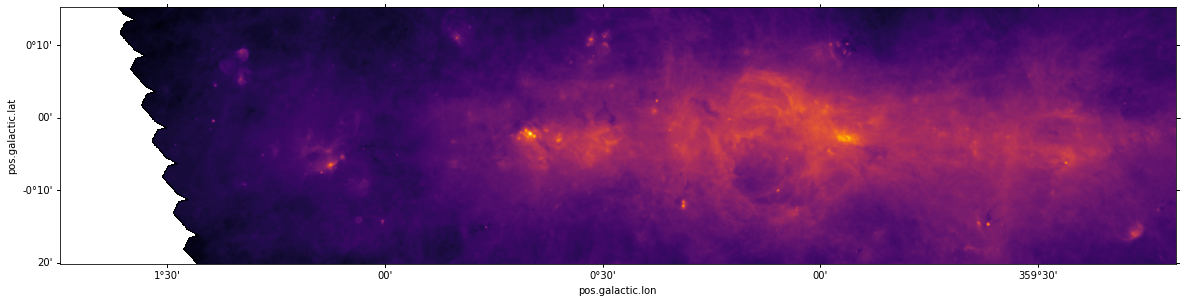

In [108]:
filename="destripe_l000_blue_wgls_rcal_cropped.fits"
fig = plt.figure(figsize=(20, 15))
file=open_files(filename) #unpacked, consists of hdu and wcs
hdu,wcs=file  

coord = plt.subplot(111, projection=wcs, slices=('x', 'y'))
lon = coord.coords[0]
lat = coord.coords[1]

coord.imshow(hdu.data,origin='lower',norm=LogNorm(), cmap='inferno')

regions = Regions.read('Terrier_2018_all.reg', format='ds9')
sub_dict=dict((k, regions[contours[k]]) for k in ('MC1', 'MC2', 'Br1','Br2'))

clouds_list=Person(sub_dict) #passing in regions and names to class




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


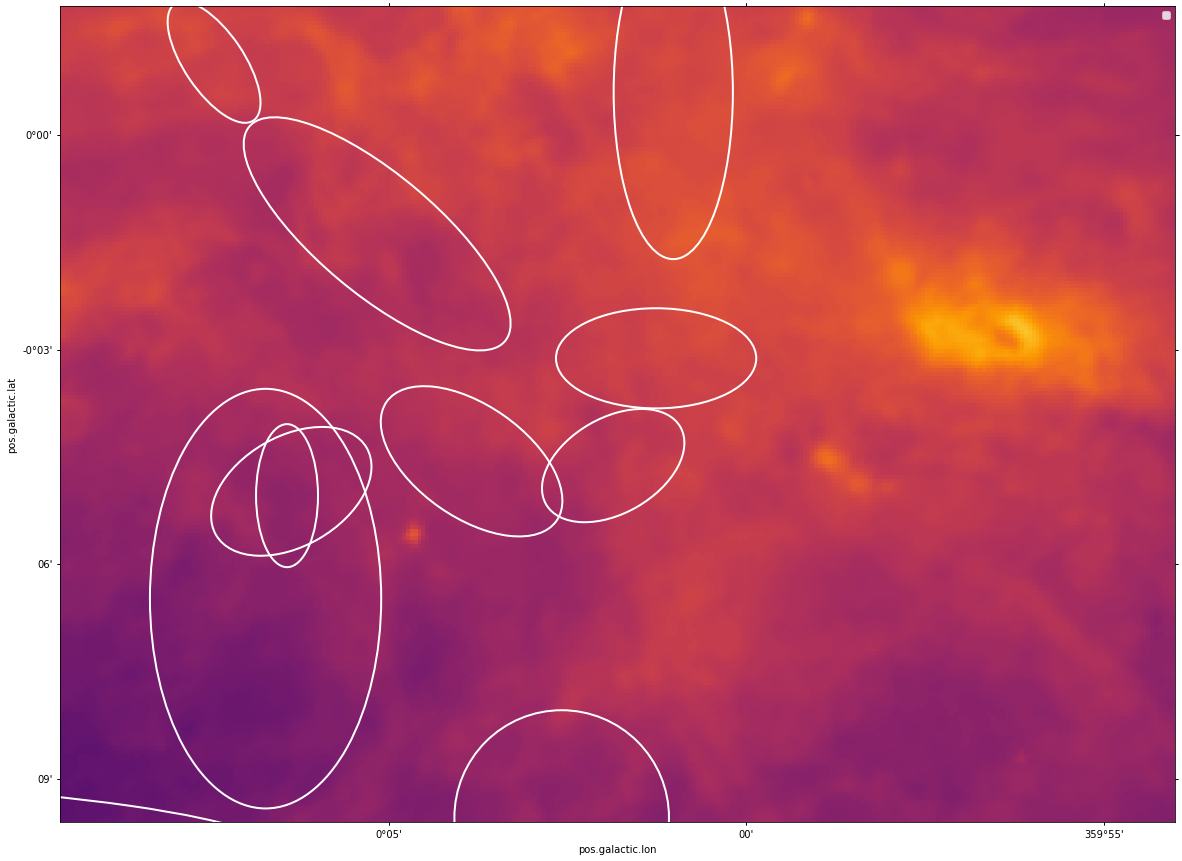

In [115]:
filename = "destripe_l000_blue_wgls_rcal_cropped.fits"
fig = plt.figure(figsize=(20, 15))

# Open and unpack FITS file (hdu and wcs)
file = open_files(filename)
hdu, wcs = file

# Set up the plot using WCS
coord = plt.subplot(111, projection=wcs, slices=('x', 'y'))
lon = coord.coords[0]
lat = coord.coords[1]

# Plot the FITS image
coord.imshow(hdu.data, origin='lower', norm=LogNorm(), cmap='inferno')
pixel_min,pixel_max= plot_coords_galactic(file,(.16,-.16),(359.90,.03))
coord.set_xlim(pixel_min[0],pixel_max[0])
coord.set_ylim(pixel_min[1],pixel_max[1])
# Read regions from the file
regions = Regions.read('Terrier_2018_all.reg', format='ds9')

# Dictionary of selected regions to pass to the Person class
sub_dict = dict((k, regions[contours[k]]) for k in ('MC1', 'MC2', 'Br1', 'Br2'))

# Create an instance of Person class with the region dictionary
clouds_list = Person(sub_dict)

# Overplot the regions from clouds_list
for region in regions:
    pixel_region = region.to_pixel(wcs)  # Convert to pixel coordinates
    pixel_region.plot(ax=coord, edgecolor='white', lw=2,fill=False)  # Plot each region

# Show the legend with cloud names
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


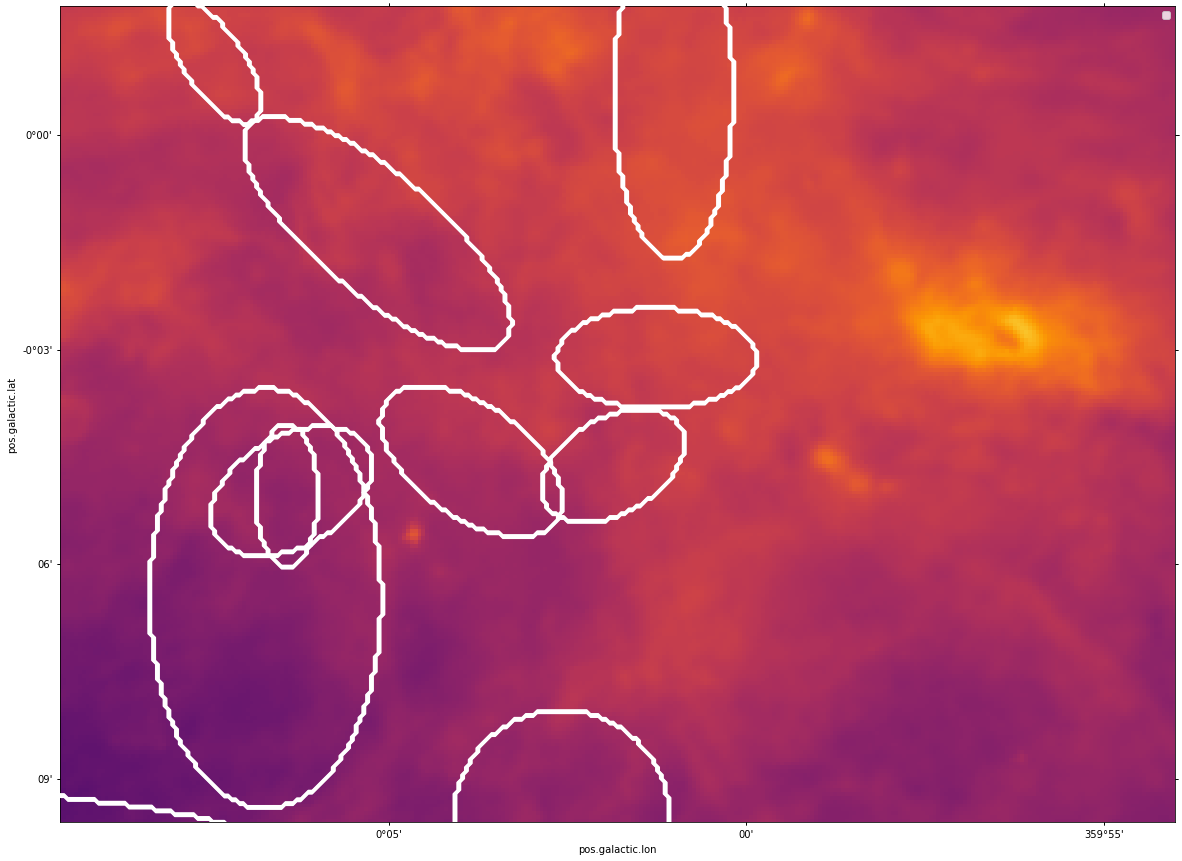

In [131]:

filename = "destripe_l000_blue_wgls_rcal_cropped.fits"
fig = plt.figure(figsize=(20, 15))

# Open and unpack FITS file (hdu and wcs)
file = open_files(filename)
hdu, wcs = file

# Set up the plot using WCS
coord = plt.subplot(111, projection=wcs, slices=('x', 'y'))
lon = coord.coords[0]
lat = coord.coords[1]

# Plot the FITS image
coord.imshow(hdu.data, origin='lower', norm=LogNorm(), cmap='inferno')
pixel_min, pixel_max = plot_coords_galactic(file, (.16, -.16), (359.90, .03))
coord.set_xlim(pixel_min[0], pixel_max[0])
coord.set_ylim(pixel_min[1], pixel_max[1])

# Read regions from the file
regions = Regions.read('Terrier_2018_all.reg', format='ds9')

# Dictionary of selected regions to pass to the Person class
sub_dict = dict((k, regions[contours[k]]) for k in ('MC1', 'MC2', 'Br1', 'Br2'))

# Create an instance of Person class with the region dictionary
clouds_list = Person(sub_dict)

# Initialize an empty mask the size of the image
image_shape = hdu.data.shape
full_mask = np.zeros(image_shape, dtype=bool)

# Overplot the regions and fill the masks
for region in regions:
    pixel_region = region.to_pixel(wcs)  # Convert to pixel coordinates

    # Create a binary mask for the region
    mask = pixel_region.to_mask(mode='center').to_image(image_shape)
    mask_bool = np.where(mask > 0, True, False)
    # Fill any holes in the mask
    full_mask = ndimage.binary_fill_holes(mask_bool)

    # Plot the filled mask (contours or filled areas) on the same axis
    coord.contour(mask ,colors='white')  # Overlay filled region
    masked_data = np.ma.masked_array(hdu.data, mask=full_mask)
    coord.imshow(masked_data, origin='lower', cmap='inferno', norm=LogNorm())
# Show the legend with cloud names
plt.legend()
plt.show()


TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

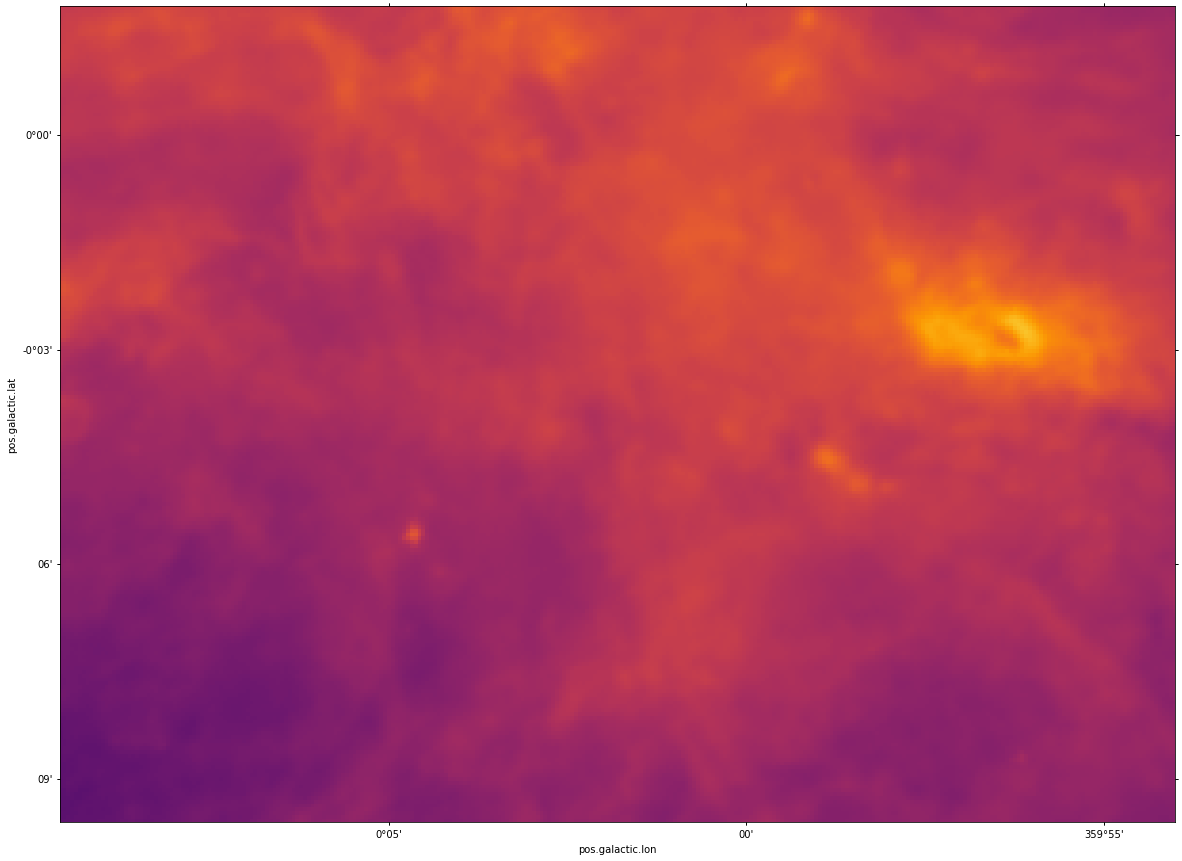

In [134]:

filename = "destripe_l000_blue_wgls_rcal_cropped.fits"
fig = plt.figure(figsize=(20, 15))

# Open and unpack FITS file (hdu and wcs)
file = open_files(filename)
hdu, wcs = file

# Set up the plot using WCS
coord = plt.subplot(111, projection=wcs, slices=('x', 'y'))
lon = coord.coords[0]
lat = coord.coords[1]

# Plot the FITS image
coord.imshow(hdu.data, origin='lower', norm=LogNorm(), cmap='inferno')
pixel_min, pixel_max = plot_coords_galactic(file, (.16, -.16), (359.90, .03))
coord.set_xlim(pixel_min[0], pixel_max[0])
coord.set_ylim(pixel_min[1], pixel_max[1])

# Read regions from the file
regions = Regions.read('Terrier_2018_all.reg', format='ds9')

# Dictionary of selected regions to pass to the Person class
sub_dict = dict((k, regions[contours[k]]) for k in ('MC1', 'MC2', 'Br1', 'Br2'))

# Create an instance of Person class with the region dictionary
clouds_list = Person(sub_dict)

# Initialize an empty mask the size of the image
image_shape = hdu.data.shape
full_mask = np.zeros(image_shape, dtype=bool)

# Overplot the regions and fill the masks
for region in regions:
    pixel_region = region.to_pixel(wcs)  # Convert to pixel coordinates

    mask |= pixel_region.to_mask(mode='center').to_image(image_shape).astype(bool)
    masked_data = np.ma.masked_array(hdu.data, ~mask)
    coord.imshow(masked_data, origin='lower', cmap='inferno', norm=LogNorm())
# Show the legend with cloud names
plt.legend()
plt.show()


In [151]:
from astropy.io import fits
import numpy as np

class IndividualMasks(Person):
    def reproject_and_save(self, file, output_filename_template):
        """
        Reprojects the mask, applies it to the data, and saves the masked FITS file for each region.

        Parameters:
        file: str
            Filename for the background file.
        output_filename_template: str
            Template for saving the masked FITS file (should include a placeholder for the region name).
        """
        # Open and unpack the FITS file
        file_data = open_files(file)
        hdu_file, wcs_file = file_data

        # Loop over each region
        for name, region in zip(self.name, self.region):
            # Convert the region to pixel coordinates
            pixel_region = region.to_pixel(wcs_file)
            
            # Create the mask for the region
            region_mask = pixel_region.to_mask(mode='center').to_image(hdu_file.data.shape)
            
            if region_mask is not None:
                ### 1. First Mask: Region with original data, background as NaN ###
                
                # Copy the original data and mask out the background (NaN for background)
                data_with_background_nan = hdu_file.data.copy()
                data_with_background_nan[~region_mask.astype(bool)] = np.nan  # Set background to NaN
                
                # Save the first FITS file (original data within mask, NaN for background)
                output_filename = output_filename_template.format(name)
                self.save_masked_fits(data_with_background_nan, wcs_file, output_filename)

    def save_masked_fits(self, data, wcs, output_filename):
        """
        Saves the masked data into a new FITS file, cropping to the area with valid data.

        Parameters:
        data: ndarray
            Data from the original file with NaNs in the background.
        wcs: WCS object
            WCS of the original file.
        output_filename: str
            Filename of the new masked FITS file.
        """
        # Mask the data to find valid entries
        masked_data = np.ma.masked_invalid(data)

        # Check if there are any valid entries
        if masked_data.count() == 0:
            raise ValueError("The data contains only NaN values; nothing to save.")
        
        # Get the bounding box of the non-NaN data
        min_y, max_y = np.where(~masked_data.mask)[0].min(), np.where(~masked_data.mask)[0].max()
        min_x, max_x = np.where(~masked_data.mask)[1].min(), np.where(~masked_data.mask)[1].max()

        # Crop the data to the bounding box and convert to a regular NumPy array
        cropped_data = masked_data[min_y:max_y + 1, min_x:max_x + 1].data

        # Create a new PrimaryHDU with the cropped masked data
        hdu = fits.PrimaryHDU(cropped_data)

        # Update the header with the WCS info
        hdu.header.update(wcs.to_header())

        # Write the masked data to a new FITS file
        hdu.writeto(output_filename, overwrite=True)
        print(f"Saved cropped masked FITS file: {output_filename}")

regions = Regions.read('Terrier_2018_all.reg', format='ds9')
# Dictionary of contour names and their region indices
contours = {
    'MC1': 0, 'MC2': 1, 'Br1': 2, 'Br2': 3, 'G0.11-0.11': 4, 'Arches': 5, 'DX': 6,
    'Fil. 2011': 7, 'G0.04-0.16': 8, 'G0.02+0.01': 9, 'G0.09-0.02': 10, 'G0.24-0.17': 11,
    'Sgr B': 12, 'Sgr B2': 13, 'G0.74-0.11': 14, 'G0.66-0.13': 15, 'G0.50-0.11': 16,
    'G0.56-0.11': 17, 'Sgr C': 18, 'C1': 19, 'C2': 20, 'C3': 21, 'C4': 22, 'M359.38-0.00': 23,
    'M359.23-0.04a': 24, 'M359.23-0.04b': 25, 'Sgr D core': 26
}
# Create a dictionary of contour names and their corresponding regions
cloud_dict = {name: regions[index] for name, index in contours.items()}

# Specify the names of the regions you want to use
selected_region_names = ['Br1', 'Br2']

# Create a filtered dictionary for the selected regions
sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}

# Instantiate the class with the selected regions
individual_masks = IndividualMasks(sub_dict)

# Call the reproject_and_save method with a template for the output filenames
individual_masks.reproject_and_save(
    'destripe_l000_blue_wgls_rcal_cropped.fits',
    'output_masked_{}.fits'  # Template where {} will be replaced by the region name
)


Saved cropped masked FITS file: output_masked_Br1.fits
Saved cropped masked FITS file: output_masked_Br2.fits


In [156]:
from astropy.io import fits
import numpy as np

class IndividualMasks(Person):
    def reproject_and_save(self, file, output_filename_template):
        """
        Reprojects the mask, applies it to the data, and saves the masked FITS file for each region.

        Parameters:
        file: str
            Filename for the background file.
        output_filename_template: str
            Template for saving the masked FITS file (should include a placeholder for the region name).
        """
        # Open and unpack the FITS file
        file_data = open_files(file)
        hdu_file, wcs_file = file_data

        # Loop over each region
        for name, region in zip(self.name, self.region):
            # Convert the region to pixel coordinates
            pixel_region = region.to_pixel(wcs_file)
            
            # Create the mask for the region
            region_mask = pixel_region.to_mask(mode='center').to_image(hdu_file.data.shape)
            
            if region_mask is not None:
                ### 1. First Mask: Region with original data, background as NaN ###
                
                # Copy the original data and mask out the background (NaN for background)
                data_with_background_nan = hdu_file.data.copy()
                data_with_background_nan[~region_mask.astype(bool)] = np.nan  # Set background to NaN
                
                # Save the first FITS file (original data within mask, NaN for background)
                output_filename = output_filename_template.format(name)
                self.save_masked_fits(data_with_background_nan, wcs_file, output_filename)

    def save_masked_fits(self, data, wcs, output_filename):
        """
        Saves the masked data into a new FITS file, cropping to the area with valid data.

        Parameters:
        data: ndarray
            Data from the original file with NaNs in the background.
        wcs: WCS object
            WCS of the original file.
        output_filename: str
            Filename of the new masked FITS file.
        """
        # Mask the data to find valid entries
        masked_data = np.ma.masked_invalid(data)

        # Check if there are any valid entries
        if masked_data.count() == 0:
            raise ValueError("The data contains only NaN values; nothing to save.")
        
        # Get the bounding box of the non-NaN data
        min_y, max_y = np.where(~masked_data.mask)[0].min(), np.where(~masked_data.mask)[0].max()
        min_x, max_x = np.where(~masked_data.mask)[1].min(), np.where(~masked_data.mask)[1].max()

        # Crop the data to the bounding box and convert to a regular NumPy array
        cropped_data = masked_data[min_y:max_y + 1, min_x:max_x + 1].data

        # Create a new PrimaryHDU with the cropped masked data
        hdu = fits.PrimaryHDU(cropped_data)

        # Update the header with the WCS info
        hdu.header.update(wcs.to_header())

        # Write the masked data to a new FITS file
        hdu.writeto(output_filename, overwrite=True)
        print(f"Saved cropped masked FITS file: {output_filename}")


# Example usage remains the same...


In [157]:
regions = Regions.read('Terrier_2018_all.reg', format='ds9')
# Dictionary of contour names and their region indices
contours = {
    'MC1': 0, 'MC2': 1, 'Br1': 2, 'Br2': 3, 'G0.11-0.11': 4, 'Arches': 5, 'DX': 6,
    'Fil. 2011': 7, 'G0.04-0.16': 8, 'G0.02+0.01': 9, 'G0.09-0.02': 10, 'G0.24-0.17': 11,
    'Sgr B': 12, 'Sgr B2': 13, 'G0.74-0.11': 14, 'G0.66-0.13': 15, 'G0.50-0.11': 16,
    'G0.56-0.11': 17, 'Sgr C': 18, 'C1': 19, 'C2': 20, 'C3': 21, 'C4': 22, 'M359.38-0.00': 23,
    'M359.23-0.04a': 24, 'M359.23-0.04b': 25, 'Sgr D core': 26
}
# Create a dictionary of contour names and their corresponding regions
cloud_dict = {name: regions[index] for name, index in contours.items()}

# Specify the names of the regions you want to use
selected_region_names = ['Br1', 'Br2']

# Create a filtered dictionary for the selected regions
sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}

# Instantiate the class with the selected regions
individual_masks = IndividualMasks(sub_dict)

# Call the reproject_and_save method with a template for the output filenames
individual_masks.reproject_and_save(
    'destripe_l000_blue_wgls_rcal_cropped.fits',
    'output_masked_{}.fits'  # Template where {} will be replaced by the region name
)


Saved cropped masked FITS file: output_masked_Br1.fits
Saved cropped masked FITS file: output_masked_Br2.fits


In [159]:
# THE ONLY RIGHT CODE, DON'T CHANGE!!!! OR YOU DIE!! THIS TOOK ME LITERALLY 5 HOURS TO TROUBLE SHOOT
from astropy.io import fits
import numpy as np

class IndividualMasks(Person):
    def reproject_and_save(self, file, output_filename_template):
        """
        Reprojects the mask, applies it to the data, and saves the masked FITS file for each region.

        Parameters:
        file: str
            Filename for the background file.
        output_filename_template: str
            Template for saving the masked FITS file (should include a placeholder for the region name).
        """
        # Open and unpack the FITS file
        file_data = open_files(file)
        hdu_file, wcs_file = file_data

        # Loop over each region
        for name, region in zip(self.name, self.region):
            # Convert the region to pixel coordinates
            pixel_region = region.to_pixel(wcs_file)
            
            # Create the mask for the region
            region_mask = pixel_region.to_mask(mode='center').to_image(hdu_file.data.shape)
            
            if region_mask is not None:
                ### 1. First Mask: Region with original data, background as NaN ###
                
                # Copy the original data and mask out the background (NaN for background)
                data_with_background_nan = hdu_file.data.copy()
                data_with_background_nan[~region_mask.astype(bool)] = np.nan  # Set background to NaN
                
                # Save the first FITS file (original data within mask, NaN for background)
                output_filename = output_filename_template.format(name)
                self.save_masked_fits(data_with_background_nan, wcs_file, output_filename)
                
    def save_masked_fits(self, data, wcs, output_filename):
        """
        Saves the masked data into a new FITS file.

        Parameters:
        data: ndarray
            Data from the original file with NaNs in the background.
        wcs: WCS object
            WCS of the original file.
        output_filename: str
            Filename of the new masked FITS file.
        """
        # Create a new PrimaryHDU with the masked data
        hdu = fits.PrimaryHDU(data)

        # Update the header with the WCS info
        hdu.header.update(wcs.to_header())

        # Write the masked data to a new FITS file
        hdu_masked = fits.HDUList([hdu])
        hdu_masked.writeto(output_filename, overwrite=True)
        print(f"Saved masked FITS file: {output_filename}")

# Example usage
regions = Regions.read('Terrier_2018_all.reg', format='ds9')
# Dictionary of contour names and their region indices
contours = {
    'MC1': 0, 'MC2': 1, 'Br1': 2, 'Br2': 3, 'G0.11-0.11': 4, 'Arches': 5, 'DX': 6,
    'Fil. 2011': 7, 'G0.04-0.16': 8, 'G0.02+0.01': 9, 'G0.09-0.02': 10, 'G0.24-0.17': 11,
    'Sgr B': 12, 'Sgr B2': 13, 'G0.74-0.11': 14, 'G0.66-0.13': 15, 'G0.50-0.11': 16,
    'G0.56-0.11': 17, 'Sgr C': 18, 'C1': 19, 'C2': 20, 'C3': 21, 'C4': 22, 'M359.38-0.00': 23,
    'M359.23-0.04a': 24, 'M359.23-0.04b': 25, 'Sgr D core': 26
}
# Create a dictionary of contour names and their corresponding regions
cloud_dict = {name: regions[index] for name, index in contours.items()}

# Specify the names of the regions you want to use
selected_region_names = ['Br1', 'Br2']

# Create a filtered dictionary for the selected regions
sub_dict = {name: cloud_dict[name] for name in selected_region_names if name in cloud_dict}

# Instantiate the class with the selected regions
individual_masks = IndividualMasks(sub_dict)

# Call the reproject_and_save method with a template for the output filenames
individual_masks.reproject_and_save(
    'destripe_l000_blue_wgls_rcal_cropped.fits',
    'output_masked_{}.fits'  # Template where {} will be replaced by the region name
)


Saved masked FITS file: output_masked_Br1.fits
Saved masked FITS file: output_masked_Br2.fits
